Version 30.08.2023, A. S. Lundervold.

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HVL-ML/DAT158/blob/master/notebooks/DAT158-1.2-extra-Intro_to_ML.ipynb)

# Introduction

This notebook is a walkthrough of some key concepts in machine learning, illustrated using a simple regression problem.

You don't have to understand the details at first. Many of the new concepts may be difficult to grasp immediately, and the code may be unfamiliar. That's not a problem! You should return to this notebook later in the course. Things will be clearer then. For now, focus on getting the gist of what's going on.

The notebook is partly based on Chapter 1 of [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book) by C.M. Bishop.

> **Again, it's recommended to revisit this notebook again later in the course, once you are more familiar with the topics covered here.**

# Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# or on Kaggle, as that makes some difference for the code below.
# We'll do this in every notebook of the course.
try:
    import google.colab
    colab=True
except:
    colab=False

import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# Problem description

Say we're in a situation where we're observing input values $x$ and want to predict corresponding output values $t$. *This kind of situation covers almost everything we'll encounter in practice!* It's all about predicting the correct output from given inputs. 

<details>
    <summary>Click <font color="red"><b>here</b></font> for some examples</summary>
  
  ![](assets/input-output.png)
</details>

```

 The beauty of machine learning is that it has vast applicability across sectors, and the fundamental principle of learning from data to make predictions or decisions remains consistent.

Say that the function generating $t$'s from $x$'s is 

$$t = \sin(2\pi x).$$

In code:

In [2]:
def f(x):
    return np.sin(2*np.pi*x)

As a graph:

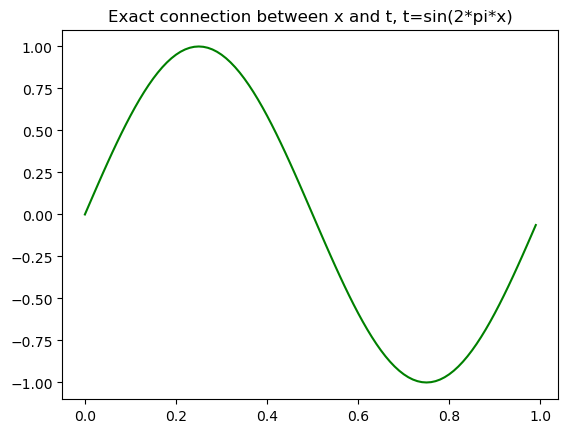

In [3]:
X_exact = np.arange(0.0, 1.0, 0.01)
plt.plot(X_exact, f(X_exact), 'g')
plt.title("Exact connection between x and t, t=sin(2*pi*x)")
plt.show()

That is, we assume that we know the underlying data generating process precisely, making it easier to explain the methods and compare results. 

> *This is of course not a typical situation. Rather, our data is usually generated by some unknowable function or process that we attempt to discover through machine learning. Moreover, often there isn't really any real functional relationship between inputs and outputs, and what we're after is more of a "probabilistic" function. We set that problem aside for now.* 

We'll pretend that we don't know the connection between $x$ and $t$, and try to discover it using machine learning methods. The methods are based on a set of observations called the **training data**. These are pairs of input-outputs:

- Observations of inputs: $\mathbf{X} = (x_1, x_2, \dots, x_N)$
- Observations of outputs: $\mathbf{y} = (y_1, y_2, \dots, y_N)$.

We generate our outputs from the above sine function, but with some added noise (simulating random variations or inaccuracies).:

In [4]:
def generate_data(N, sigma, seed=42):
    """
    Generate N data points sampled uniformly at random, 
    with noise added to the labels (sampled from the 
    normal distribution with standard deviation sigma). 
    Seed set to 42 by default.
    Return: X, y
    """
    np.random.seed(seed)
    
    # Random values between 0 and 1 sampled uniformly
    X = np.random.rand(N)
    
    # Corresponding values of T, with some added noise
    y = f(X) + sigma*np.random.randn(N)
    
    return X, y

We'll use `N` training data points, with a noise level specified by `sigma`:

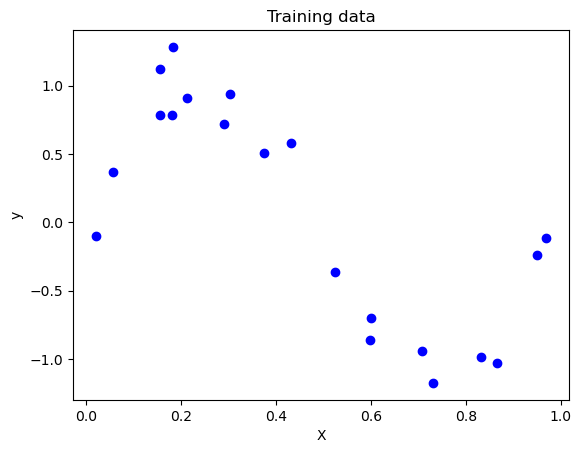

In [5]:
N_train = 20
sigma=0.2

X_train, y_train = generate_data(N=N_train, sigma=sigma)

plt.plot(X_train, y_train, 'bo')
plt.xlabel('X')
plt.ylabel('y')
plt.title("Training data")
plt.show()

Let's plot the training data on top of the exact values to better illustrate our situation:

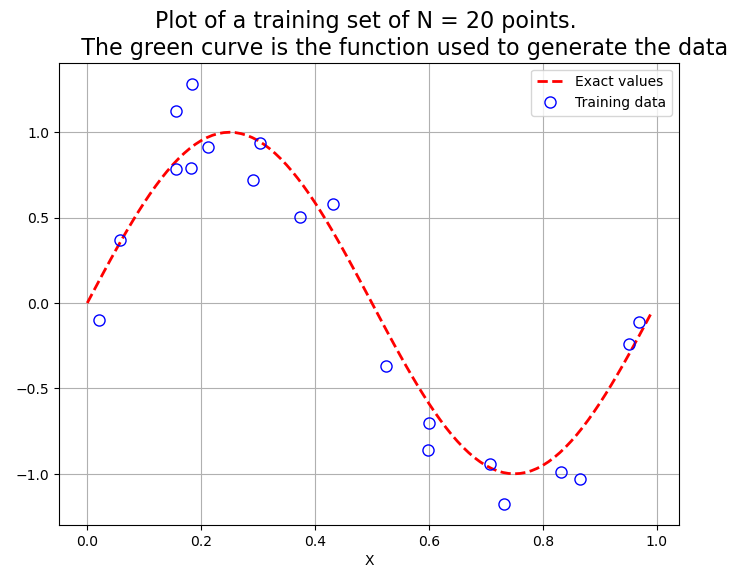

In [6]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X_exact, f(X_exact), 'r--', linewidth=2, 
        label='Exact values')
ax.plot(X_train, y_train, 'bo', markersize=8, 
        fillstyle='none', label='Training data')

plt.xlabel('X')
plt.title(f'''Plot of a training set of N = {N_train} points. 
          The green curve is the function used to generate the data''', fontsize=16)

ax.legend()
ax.grid()
plt.show()

We can make this interactive to better understand the effect of the number of points (N) and the noise level (sigma):

In [7]:
from ipywidgets import interact

In [8]:
@interact
def plot_data(N=(1, 100, 1), sigma=(0.01, 1.0, 0.01)):
    fig, ax = plt.subplots(figsize=(8,6))
    X, y = generate_data(N, sigma)

    ax.plot(X_exact, f(X_exact), 'r--', linewidth=2, 
        label='Exact values')
    ax.plot(X, y, 'bo', markersize=8, 
        fillstyle='none', label='Training data')
        
    plt.xlabel('X')
    plt.ylabel('y')
    plt.ylim(-1.7, 1.7)
    plt.title(f"Training data, N={N}, sigma={sigma}")
    plt.grid(True)
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=50, description='N', min=1), FloatSlider(value=0.5, description='sigma',…

This is a very common situation: you'll have a bunch of data points generated by an (unknown) **underlying process**, with some **noise** or **uncertainties**. 

The data points can be images, sounds, sales data from a store, patient journals from a hospital, measurements from a laser, whatever. The underlying process can be anything from a physical process to a human decision process. 

There are many possible sources of uncertainty; often, things we cannot model precisely. For example, there can be inherent uncertainty in the phenomenon. Or uncertainty caused by a measuring instrument. Or irreversible noise caused by data compression or some other process we cannot control. 

> **Goal**: Use the training data to predict output values given *new* values of $x$. 

More precisely:

> **Problem Statement:** Given a set of input values, $X$, and their corresponding noisy outputs, $y$, we aim to discover the underlying relationship between them, represented by a function $f(x)$, using machine learning techniques.

In other words, try to find &ndash; or more realistically, **approximate** &ndash; the underlying data-generating function. 

# How to solve it: an idea

Let's attack the problem by choosing a family of functions equipped with some adaptive parameters. Concretely, let's use **polynomials**. We'll try to find polynomials that fit "best" with the training data. 

> Polynomials are versatile, simple to compute, and can be easily differentiated and integrated. They provide a convenient first step into understanding the world of regression.

More precisely, we'll use functions of the form

$$P(x, \mathbf{w}) = w_0 + w_1 x + w_2 x^2 + \cdots + w_M x^M,$$

that we tune to the training data we've been given.

Here $\mathbf{w}$ are the *coefficients* of the polynomial&ndash;the tweaking of which makes the function _adaptive_&ndash;and $M$ is its *degree* (a non-negative integer). We want to find the values of $\mathbf{w}$ and $M$ that gives us the 
> **best predictions for new, previously unseen values of $x$**.

There are two things we can tweak in our models, i.e., two _parameters_: $\mathbf{w}$ and $M$. 

> But what do we mean by "best"?

Let's think about that by first trying to fit the training data using a fixed value of the degree $M$. 

## A naive approach: trial and error

Say we decide that we want to use a third degree polynomial (a cubic) to model the data. One approach to find the best approximation is to try out a bunch of values for the coefficient of our model and see which one fits the data best (for some definition of "best"--for now, we'll use visual inspection). 

In [9]:
# Here's a function for constructing cubic polynomials:

def cubic(w0, w1, w2, w3):
    return lambda x: w0 + w1*x + w2*x**2 + w3*x**3

In [10]:
from ipywidgets import interact

We can use some sliders to change the coefficient of the polynomial to try to find the best fit:

In [11]:
@interact(w0=0.0, w1=10, w2=-25, w3=15)
def plot_cubic(w0, w1, w2, w3):

    # Plot the generated noisy data
    N_train = 100
    sigma=0.2
    X_train, y_train = generate_data(N=N_train, sigma=sigma)

    plt.figure(figsize=(8,6))
    plt.scatter(X_train, y_train, label="Data", s=10)


    # Plot the cubic approximation
    plt.plot(X_exact, cubic(w0, w1, w2, w3)(X_exact), "r",
                label="Cubic Approximation")


    # Set limits, add axis labels and title
    plt.ylim(-2, 2)
    plt.xlabel("X")
    plt.ylabel("y")
    plt.title("Cubic Approximation of Noisy Data")

    # Add legend
    plt.legend()

interactive(children=(FloatSlider(value=0.0, description='w0', max=1.0), IntSlider(value=10, description='w1',…

After some experimentation, you may be able to find a model that's reasonable. However, this is, of course, not a very useful approach to solving the problem! We need a way to automatically find a good model. This is where machine learning comes in. But first, we need a way to measure the error of a model. 

<details>
    <summary>Click <font color="red"><b>here</b></font> to see the coefficients for the optimal cubic polynomial</summary>
  
  $w_0=0, w_1=10, w_2=-30, w_3=20$ 
</details>


## Measuring the error

We can measure how well a polynomial fits the training data by measuring the **approximation error**. If the error is low, the fit is good. If the error is high, the fit is bad.

A convenient error function for regression problems is the **sum of squared errors** between the predictions $P(x_n, \mathbf{w})$ for each data point $x_n$ and the corresponding output values $t_n$:

$$E(\mathbf{w}) = \sum_{n=1}^N \big(P(x_n, \mathbf{w}) - t_n \big)^2$$

Notice that $E=0$ exactly when the polynomial passes through *all* the training data points $(x_n , t_n)$. The error is zero when the approximation is perfect. 

Error functions are sometimes also called **cost functions** or **loss functions**. They compute the *cost* of using the current parameters of the model (the weights, in our case). 

Here's the same function in code:

In [12]:
def error(P, x, t):
    """
    Computes the sum of squared errors when using y to 
    approximate the true values t at the points x
    """
    
    return np.sum( (P(x) - t)**2 )

We can modify the above interactive plot so that it displays the error as we try out values for the coefficients:

In [13]:
@interact(w0=0.0, w1=10, w2=-25, w3=15)
def plot_cubic(w0, w1, w2, w3):

    # Plot the generated noisy data
    N_train = 20
    sigma=0.2
    X_train, y_train = generate_data(N=N_train, sigma=sigma)

    plt.figure(figsize=(8,6))
    plt.scatter(X_train, y_train, label="Data", s=10)


    # Plot the cubic approximation
    plt.plot(X_exact, cubic(w0, w1, w2, w3)(X_exact), "r",
                label="Cubic Approximation")


    # Add error lines
    for x, y_true in zip(X_train, y_train):
        y_pred = cubic(w0, w1, w2, w3)(x)
        plt.plot([x, x], [y_true, y_pred], "k--")


    # Set limits, add axis labels and title
    plt.ylim(-2, 2)
    plt.xlabel("X")
    plt.ylabel("y")
    # Display the error as the plot title
    plt.title(f"Error: {error(cubic(w0, w1, w2, w3), X_train, y_train):.3f}")

    # Add legend
    plt.legend()

interactive(children=(FloatSlider(value=0.0, description='w0', max=1.0), IntSlider(value=10, description='w1',…

But there's a way to automatically find the coefficients that minimizes the error! **Calculus**!

By setting the derivative of $E$ to zero, trying to find the values of $\mathbf{w}$ that minimize $E$ (a strategy you remember from calculus), it turns out that it's possible to precisely determine the values of $\mathbf{w}$ that minimize the error. If you're curious about the details, have a look [here]() for a sketch of how it's done.

Here are some plots of polynomials of varying degree $M$ that all minimize $E$:

In [14]:
def plot_poly_approx(degree, title=""):

    #X values used to plot the polynomial:
    x_poly = np.linspace(0,1,100)
    # Corresponding values of the polynomial:
    y_poly = P(x_poly)
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.plot(X_exact, f(X_exact), 'g', label='Exact values')
    ax.plot(X_train, y_train, 'bo', label="Training data")
    ax.plot(x_poly, y_poly, 'r', label="Polynomial")
    
    ax.legend()
    
    plt.ylim(-1.5, 1.5)
    plt.title(title)
    plt.show()
    return ax

 
0.07446


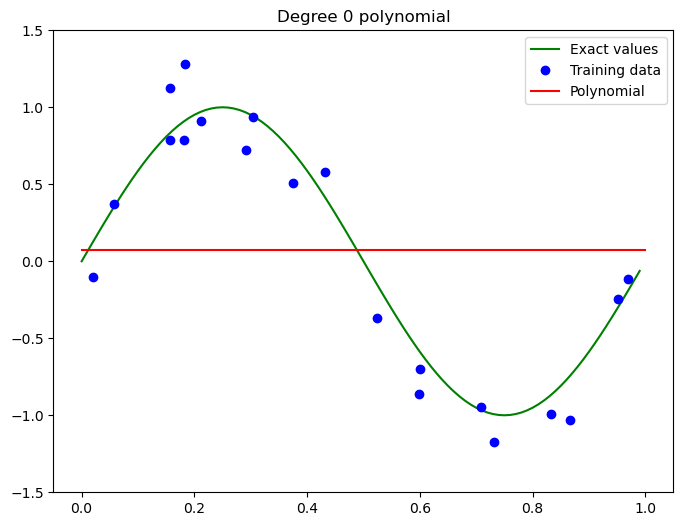

 
-1.984 x + 0.9827


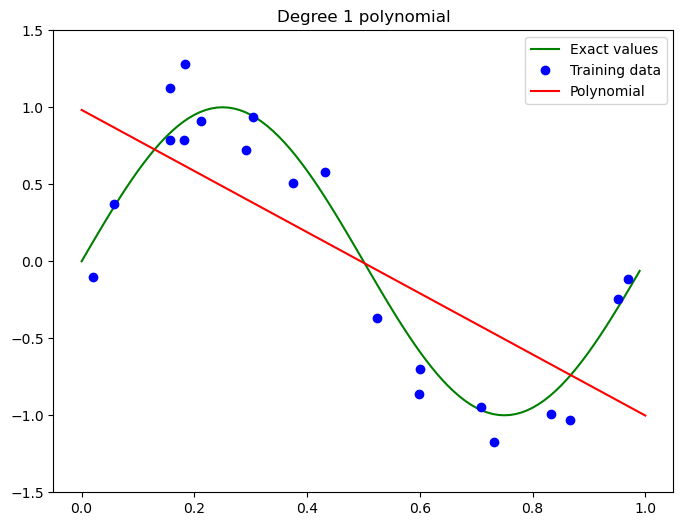

       3         2
26.45 x - 39.15 x + 13.34 x - 0.3076


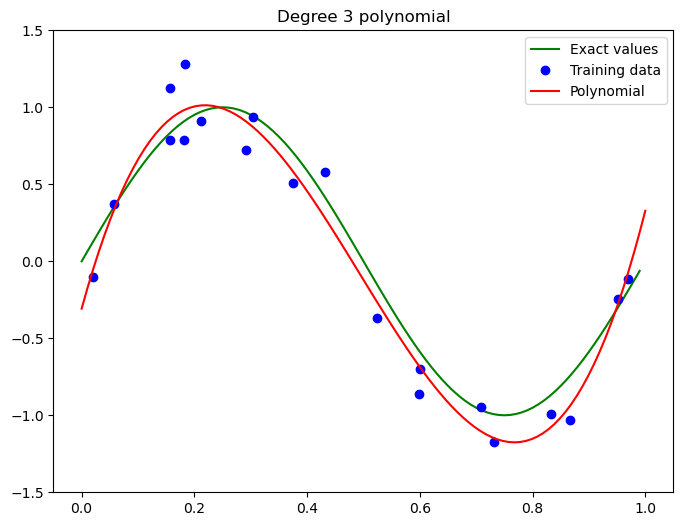

            9             8             7             6             5
-1.486e+04 x + 6.693e+04 x - 1.258e+05 x + 1.276e+05 x - 7.544e+04 x
              4        3         2
 + 2.618e+04 x - 5062 x + 453.5 x - 5.05 x - 0.1438


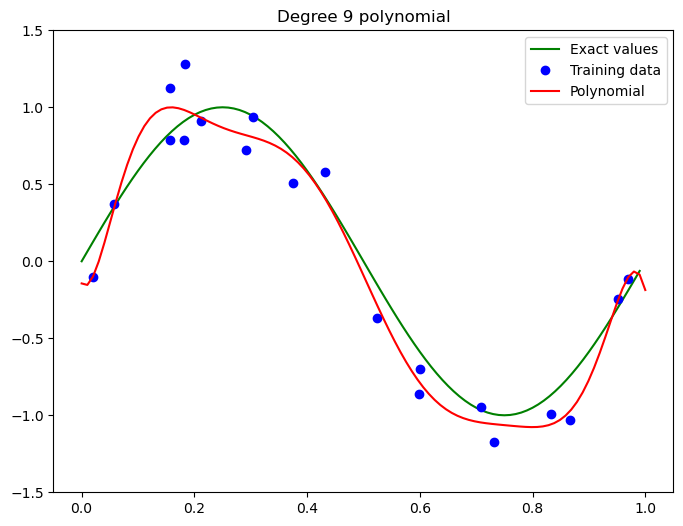

            20             19            18             17
-3.412e+09 x  + 2.549e+10 x  - 7.38e+10 x  + 9.542e+10 x 
              16            15             14             13
 - 2.283e+10 x  - 7.85e+10 x  + 6.259e+10 x  + 5.128e+10 x 
              12             11             10             9
 - 9.184e+10 x  + 5.205e+09 x  + 9.267e+10 x  - 1.105e+11 x
              8             7             6             5             4
 + 7.087e+10 x - 2.966e+10 x + 8.539e+09 x - 1.707e+09 x + 2.332e+08 x
              3             2
 - 2.085e+07 x + 1.126e+06 x - 3.135e+04 x + 314


/tmp/ipykernel_20731/3839858602.py:4: RankWarning: Polyfit may be poorly conditioned
  P = np.poly1d(np.polyfit(X_train, y_train, deg=M))


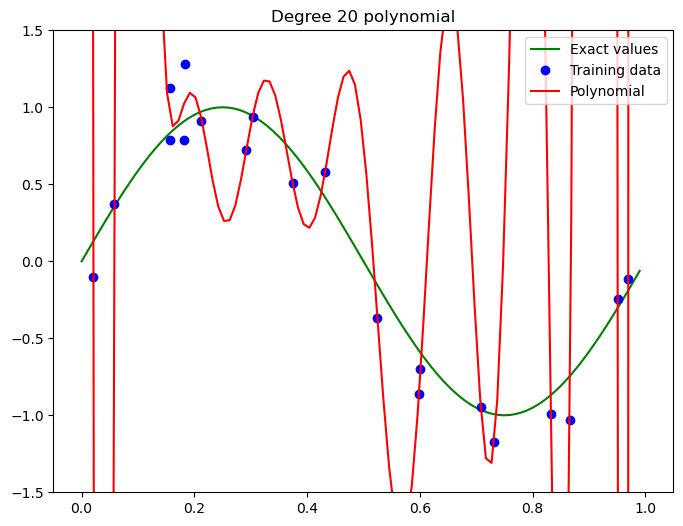

In [15]:
degrees = [0, 1, 3, 9, 20]

for M in degrees:
    P = np.poly1d(np.polyfit(X_train, y_train, deg=M)) 
    print(P)
    # The above functions minimize the error E for us
    plot_poly_approx(M, title=f"Degree {M} polynomial")

## Which of these models should we use?

We notice that the order of the polynomial makes a huge difference! 

So which model do we choose? Which one's "best"? 

For sure, $M=0$ and $M=1$ seems like bad models: they're too far from the training data points. On the other hand, $M=9$ gives us an excellent fit to the training data, with very low error. But we have the luxury of having access to the true, exact function, and it's obvious that $M=9$ results in a horrible model for $\sin(2*pi*x)$...

What's happening to the high-degree polynomials like $M=9$ is what's called **overfitting**, a fundamental concept in machine learning. The model *tries too hard* to fit the training data and ends up being a bad fit to the true solution. 

> Think of overfitting as memorizing facts for an exam without understanding them. You'll do great if asked the exact facts, but if you encounter a slightly different question, you'll likely answer incorrectly.

Imagine we're given a new data point $x$ that's not from the training data. The model with $M=9$ will likely provide a foolish prediction for the corresponding value of $t$. It's bad at **generalization**. And generalization ability is exactly what we're after: we want models that can give good predictions of $t$ for new, previously unseen values of $x$. We want them to perform well on data they've never seen before!

> Generalization is the real power of a machine learning model. It's not just about fitting to the data we have, but predicting accurately on new, unseen data.

$M=3$ seems to hit a sweet spot in our case. 

> How can we make these observations more precise?

> How can we find good models when we don't have access to the true solution (which in practice is always)?

Soon, we'll see some tools that help us automatically select the best model, without the need for the 'true' function.

## How to measure model performance and find the best model?

One of the main ideas in machine learning&ndash;and the way we'll tackle these problems&ndash; is to use 
> **train, validation, and test sets**

Recall (again) that our goal is to create a model that can produce accurate predictions for previously unseen data points. To estimate model performance, we set aside some of our data points as a **test set** and disregard them during the training of the model. 

The test set can then be used to *simulate* what will happen when new points are put into the trained model and to quantify its performance. 

One standard way to do this is to set aside approximately 20% of the data we've been given for testing and use the remainder for training (using, for example, scikit-learn's `train_test_split` function).

In our situation, we can easily produce new data since we know the data generating function, and we can leave the $N$ points we already have for training the models. However, note that in practice, this is not typically how it's done since you cannot easily collect more data. You have to use what you've got.

In [16]:
# Test data
N_test = 100
X_test, y_test = generate_data(N_test, sigma, seed=0)

Here's the training and test data:

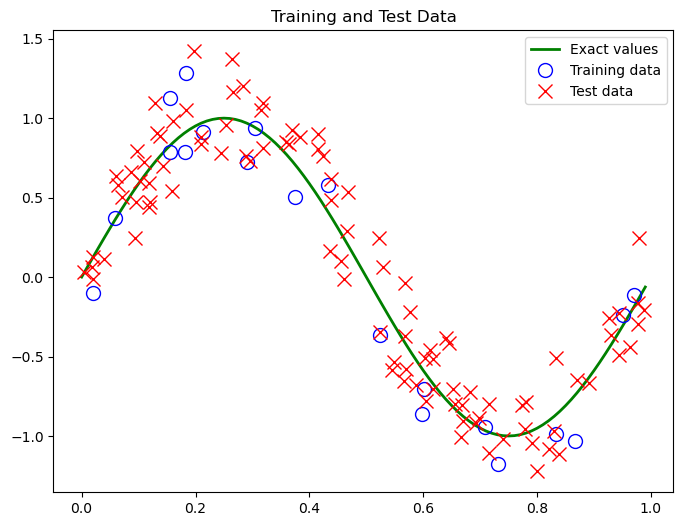

In [17]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(X_exact, f(X_exact), 'g', linewidth=2, 
        label='Exact values')
ax.plot(X_train, y_train, 'bo', markersize=10, fillstyle='none', 
        label='Training data')
ax.plot(X_test,y_test, 'rx', markersize=10, fillstyle='none', 
        label='Test data')
ax.legend()
plt.title('Training and Test Data')
plt.show()

Now we can plot how the polynomials perform in terms of the error function E as we increase the degree from 0 to 9. 

It's convenient (and standard) to change the error function slightly and use the **root mean square** error function:

$$\displaystyle{RMS(\mathbf{w}) = \sqrt{E(\mathbf{w})/N}}$$

(It has the advantage of dividing being on the same scale as the target variable $t$ (because of the square root). The division by $N$ lets us compare the error on data sets of different sizes.)

In code:

In [18]:
def rmserror(P, x, t):
    """
    Returns the root mean square error 
    """
    err = error(P,x,t)
    
    return np.sqrt(err/len(x))

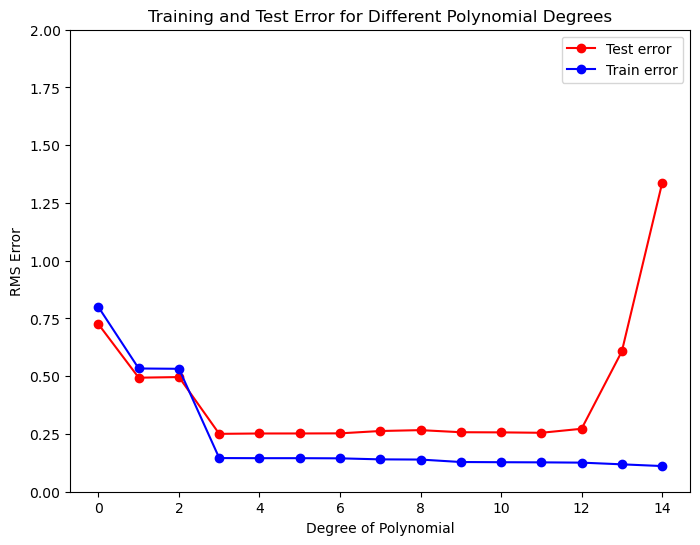

In [19]:
trainerrors = []
testerrors = []
degrees = range(0,15)
for deg in degrees:
    P = np.poly1d(np.polyfit(X_train, y_train, deg=deg))
    trainerrors.append(rmserror(P, X_train, y_train))
    testerrors.append(rmserror(P, X_test, y_test))
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(degrees, testerrors, '-ro', label="Test error")
ax.plot(degrees, trainerrors, '-bo', label="Train error")
plt.ylim(0,2)
ax.legend(loc='best')
plt.xlabel("Degree of Polynomial")
plt.ylabel("RMS Error")
plt.title("Training and Test Error for Different Polynomial Degrees")
plt.show()


Now we can see what's happening. The models with low $M$ aren't able to capture the function $\sin(2\pi x)$ and have a relatively high error on the test set. The models with high $M$ have extremely low training error (as low as 0 for the polynomial of degree 9, which is able to capture the training data perfectly) but high test error.

The models in-between, say in the range $3 \leq M \leq 5$, give reasonable approximations to the training data *and* have relatively low test error. They're in the sweet spot, neither underfitting nor overfitting, having good generalization capabilities. 

We've used a data set not used directly in training to find suitable values for the degree of the polynomial. The degree is a **hyperparameter** of our models: a parameter we can use to control our model that is not set by the learning algorithm itself, but they influence model performance. We often use the validation set to fine-tune them.

## The impact of data size

An important side-note is that whether a model will overfit a training data set is typically very much dependent on the size of the data set! 

Typically, small datasets increase the risk of overfitting, especially with complex models. As the data size grows, this risk diminishes.

Let's give it a try:

In [20]:
# Size of data set
N_train = 100
# Degree of polynomial
M = 9

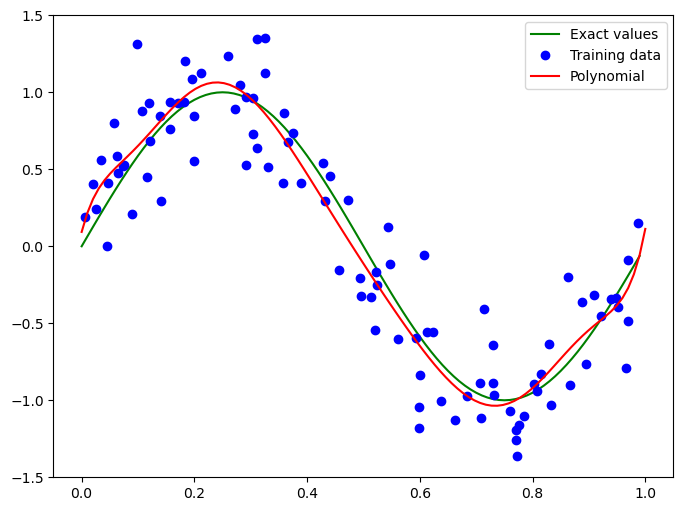

In [21]:
# Generate training data as before
X_train, y_train = generate_data(N_train, 0.3)

# Polynomial approximation
P = np.poly1d(np.polyfit(X_train, y_train, deg=M))

# Plot the data and the polynomial approximation
_ = plot_poly_approx(M)

Now the complex model gives a good approximation. Both visually, and in terms of the error:

In [22]:
rmserror(P, X_test, y_test)

0.2295847618663145

You can play around with the effect of choosing various N's and M's below:

In [23]:
def get_rmserror(N_train, M=9):
    X_train, y_train = generate_data(N_train, 0.3)
    P = np.poly1d(np.polyfit(X_train, y_train, deg=M))
    return rmserror(P, X_test, y_test)

In [24]:
from ipywidgets import interact, interactive

In [25]:
_ = interact(get_rmserror, N_train=(10,100), M=(0,15))

interactive(children=(IntSlider(value=55, description='N_train', min=10), IntSlider(value=9, description='M', …

Here's a visualization of the effect of choosing different values for N and M:

In [26]:
def generate_plot_poly_approx(N, M):
    """
    Generates a plot of a polynomial approximation of noisy data.

    Parameters:
    N (int): The number of data points to generate.
    M (int): The degree of the polynomial to use for the approximation.

    Returns:
    None
    """
    plt.figure(2)
    X, y = generate_data(N, 0.3)
    P = np.poly1d(np.polyfit(X, y, deg=M))
    #X values used to plot the polynomial:
    X_poly = np.linspace(0,1,100)
    # Corresponding values of the polynomial:
    y_poly = P(X_poly)
    
    fig, ax = plt.subplots(figsize=(10,8))
    
    ax.plot(X_exact, f(X_exact), 'g', label='Exact values')
    ax.scatter(X, y, s=20, c='b', label="Training data")
    ax.plot(X_poly, y_poly, 'r', '--', label="Polynomial approximation")
    
    ax.legend()
    
    plt.ylim(-1.5, 1.5)
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title(f"Polynomial approximation of noisy data (N={N}, M={M})")
    plt.show()

Let's make it interactive:

In [27]:
interactive_plot = interactive(generate_plot_poly_approx, N=(10, 100), M=(0, 15))
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

interactive(children=(IntSlider(value=55, description='N', min=10), IntSlider(value=7, description='M', max=15…

Too little data with a high-degree polynomial? You'll overfit. Lots of data with a simple model? You might underfit.

## So, how do we choose M?

You might think, "Just pick the model with the lowest test error!" But wait. 

> **That's not a good plan!** 

Why? Because by using the test set to tune the parameter $M$ then information from the test set leaks into the model construction process! The test set is to be kept totally separate and only used to test the final model. Otherwise, *it wouldn't provide a good simulation of the situation we're really interested in!* Which is when new, previously unseen points appear that we're supposed to make predictions for. It could happen that, by chance, a certain value of $M$ is particularly good for the test set we happen to have but very bad for new data points. That would be a model that fails to generalize well.

This is super important and worth repeating:
> **In machine learning, you keep your hands off the test set during model construction!**

If you're not careful, you may end up *overfitting to the test set*. Then what do you do to estimate the model's performance? If the model fit the test set really well because we tuned it that way, there's no way of knowing how good it will be once we put it in production. 

So, what do we do? We divide the training set into *three* parts. 

- A **training set** used to create the model
- A **validation set** used to tune the parameters of the model (model selection)
- A **test set** to test the final model. The performance of the model on the test set is used as an estimate of its "true" performance. 

We'll make this split all the time throughout the course, primarily using the `train_test_split` function of scikit-learn.

Again, in our special case where we know the data generating function precisely, it's easy to generate *new* data for validation and test:

In [28]:
# Training data
N_train = 70
X_train, y_train = generate_data(N_train, sigma)

In [29]:
# Validation data
N_val = 20
X_val, y_val = generate_data(N_val, sigma, seed=0)

In [30]:
# Test data
N_test = 10
X_test, y_test = generate_data(N_test, sigma, seed=1)

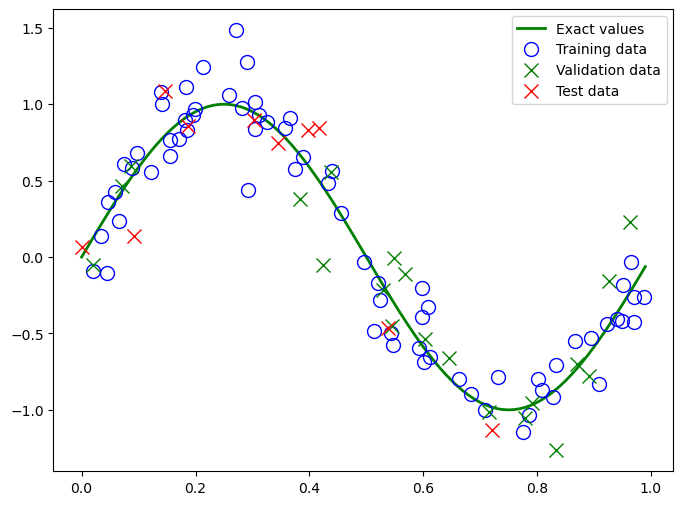

In [31]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(X_exact, f(X_exact), 'g', linewidth=2, label='Exact values')
ax.plot(X_train,y_train, 'bo', markersize=10, fillstyle='none', label='Training data')
ax.plot(X_val,y_val, 'gx', markersize=10, fillstyle='none', label='Validation data')
ax.plot(X_test,y_test, 'rx', markersize=10, fillstyle='none', label='Test data')
ax.legend()
plt.show()

And now, let's find the best model:

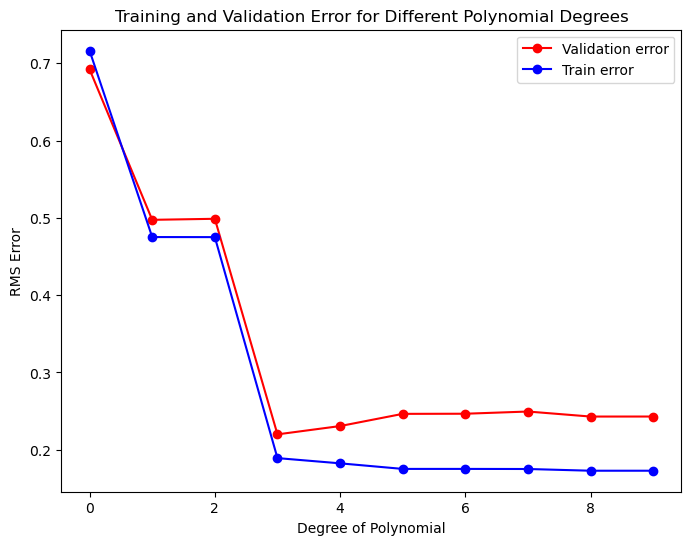

In [32]:
trainerrors = []
testerrors = []
degrees = range(0,10)
for deg in degrees:
    P = np.poly1d(np.polyfit(X_train, y_train, deg=deg))
    trainerrors.append(rmserror(P, X_train, y_train))
    testerrors.append(rmserror(P, X_val, y_val))
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(degrees, testerrors, '-ro', label="Validation error")
ax.plot(degrees, trainerrors, '-bo', label="Train error")
plt.xlabel("Degree of Polynomial")
plt.ylabel("RMS Error")
plt.title("Training and Validation Error for Different Polynomial Degrees")
ax.legend(loc='best')
plt.show()

$M=3$ seems like a good choice. 

In [33]:
our_model = np.poly1d(np.polyfit(X_train, y_train, deg=3))

Test error:

In [34]:
rmserror(our_model, X_test, y_test)

0.270452807064821

Pretty good. Let's plot the result:

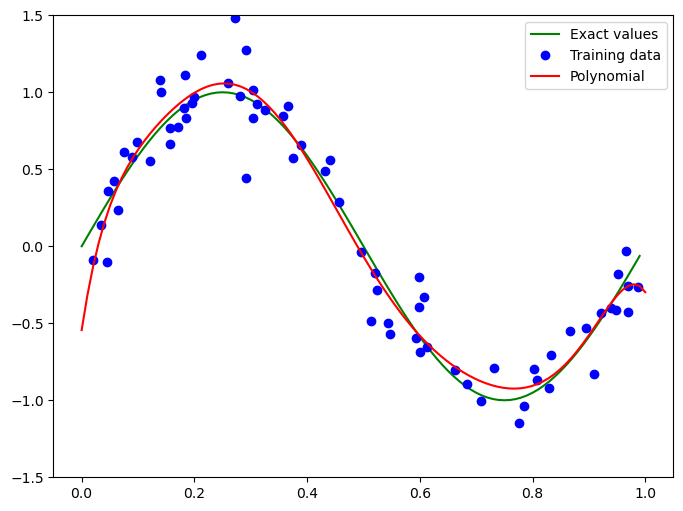

In [35]:
plot_poly_approx(5)
plt.show()

### Why Can't Models Decide Their Complexity?

> Why can't complex models figure out that they're being *too complex* themselves? Why do *we* have to do it?

One of our goals in machine learning is after all to get the computers to do as much of the work as possible. That should include giving us the best models for the job. 

Ideally, we'd want models to determine the best level of complexity themselves. Fortunately, there's a mechanism for this – regularization. More on that in the next section!

## Regularization

Overfitting can cause our model to capture the noise in the training data rather than the underlying distribution. Let's revisit the overfitting polynomial to see this in action:

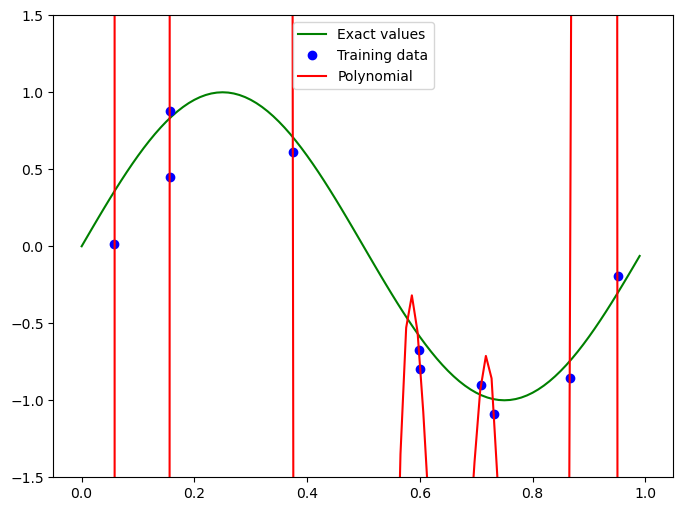

In [36]:
N_train = 10
sigma=0.2
X_train, y_train = generate_data(N=N_train, sigma=sigma)

P = np.poly1d(np.polyfit(X_train, y_train, deg=M))
plot_poly_approx(M)
plt.show()

We can have a closer look at the 10 coefficients of P

$$w_0 + w_1 x + w_2 x^2 + \cdots + w_9 x^9$$

In [37]:
P.coefficients

array([-2.52428059e+07,  1.26612372e+08, -2.72807857e+08,  3.29392637e+08,
       -2.43526351e+08,  1.12930084e+08, -3.22430069e+07,  5.30591131e+06,
       -4.34627189e+05,  1.25259695e+04])

They're huge! These coefficients have been precisely calibrated to fit the training data, which results in high oscillations between data points and reduced generalization capabilities.

Remember that the error function minimized to determine these coefficients is:

$$E(\mathbf{w}) = \sum_{n=1}^N \big(y(x_n, \mathbf{w}) - t_n \big)^2$$

To curb overfitting, let's add a _penalty term_ that promotes smaller coefficient values:

$$\tilde{E}(\mathbf{w}) = \sum_{n=1}^N \big(y(x_n, \mathbf{w}) - t_n \big)^2 + \lambda |\mathbf{w}|^2$$

Remember that we're trying to minimize the error. Using the above expression this will automatically also try to minimize the size $|\mathbf{w}| = w_0^2 + \cdots + w_N^2$ of the coefficients. 

This is an example of what's called **regularization** and is used throughout machine learning. In general, regularization is a way to put preferences into our models in such a way that the generalization error is reduced, but not the error on the training set.

The parameter $\lambda$ balances the model's fit to the data against the magnitude of the polynomial's coefficients.

Using regularization, let's see if we can fit a degree 9 polynomial to our training data. 

Let's employ regularization using `scikit-learn`:

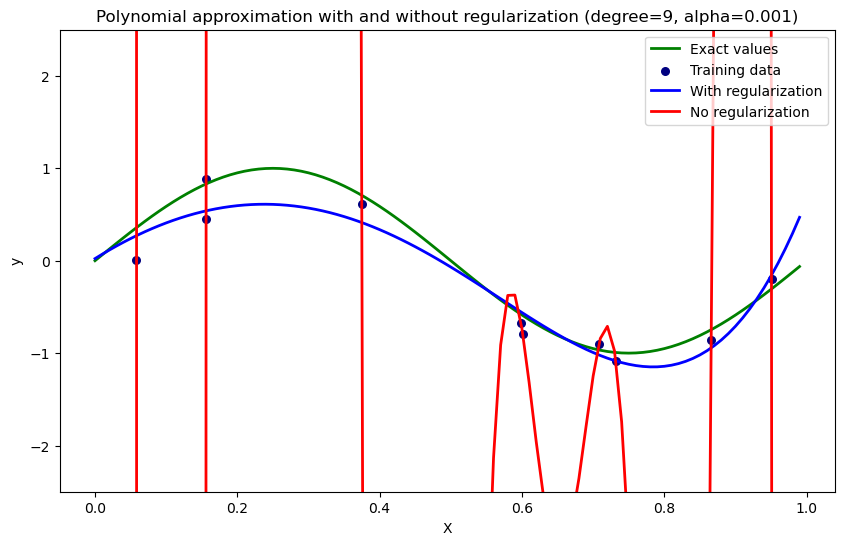

In [38]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Data
X_exact = np.arange(0.0, 1.0, 0.01)
y_exact = f(X_exact)

# Trick to make scikit-learn happy
X_train_array = X_train[:, np.newaxis]
y_train_array = y_train[:, np.newaxis]
X_exact_array = X_exact[:, np.newaxis]
y_exact_array = y_exact[:, np.newaxis]

# Plot of exact function and our training data
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(X_exact, y_exact, color='green', linewidth=2,
         label="Exact values")
plt.scatter(X_train, y_train, color='navy', s=30, marker='o', label="Training data")

# Polynomial approximation without regularization
degree=9
P = np.poly1d(np.polyfit(X_train, y_train, deg=degree))

# Polynomial approximation with regularization (using scikit-learn)
alpha = 0.001 
# alpha is the amount of regularization. 
# It's proportional to 1/lambda in the formula above

model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
model.fit(X_train_array, y_train_array)
y_pred_regr = model.predict(X_exact_array)

# Plot of the resulting polynomials
ax.plot(X_exact, y_pred_regr, color='blue', linewidth=2,
             label="With regularization")
ax.plot(X_exact, P(X_exact), color='red', linewidth=2,
             label="No regularization")

# Add axis labels and title
plt.xlabel('X')
plt.ylabel('y')
plt.title(f"Polynomial approximation with and without regularization (degree={degree}, alpha={alpha})")

# Add legend
ax.legend()

plt.ylim(-2.5, 2.5)

plt.show()

> **Your turn!:** 
- Adjust the regularization strength with different values for `alpha`. Try `alpha = 0`. What happens? Why? Then try `alpha = 0.1`. 
- Make a plot where the x-axis is the amount of regularization and the y-axis is the `rmserror`, showing both the training set and the test set error for the degree 9 polynomial above.

Regularization helps combat overfitting! 

This is evident from the considerably smaller coefficients:

In [39]:
model.named_steps.ridge.coef_

array([[ 0.        ,  4.7917594 , -8.89014022, -4.11433992,  1.13493122,
         3.48798632,  3.50297831,  2.18353155,  0.28177652, -1.74292502]])

For comparison:

In [40]:
P.coef

array([-2.52428059e+07,  1.26612372e+08, -2.72807857e+08,  3.29392637e+08,
       -2.43526351e+08,  1.12930084e+08, -3.22430069e+07,  5.30591131e+06,
       -4.34627189e+05,  1.25259695e+04])

**How do we select the best regularization parameter in practice?**

> Using the validation set! Never use the test set to select *any* of the parameters of your model!

# End of crash course; more about these topics later in the course.